In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten,
                                     Dense, Dropout, BatchNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

# Confirm GPU
print("GPU devices:", tf.config.list_physical_devices('GPU'))

# Global config
IMG_SIZE = 28
BATCH_SIZE = 64
EPOCHS = 50
LEARNING_RATE = 0.0001
tf.keras.backend.clear_session()

GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [12]:
# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Load images from folders
train_gen = train_datagen.flow_from_directory(
    'dataset/train',
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    'dataset/val',
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Compute class weights for balanced training
y_train_classes = train_gen.classes
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_classes),
    y=y_train_classes
)
class_weights_dict = dict(enumerate(class_weights_array))

Found 6895 images belonging to 10 classes.
Found 1969 images belonging to 10 classes.


In [15]:
model = Sequential([
    # Block 1
    Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    Conv2D(64, (1, 1), padding='same', activation='relu'),  # add 1x1 conv to capture narrow features
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Block 2
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Block 3
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # Dense layers
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])


model.summary()

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 64)     │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 450,250 (1.72 MB)

 Trainable params: 450,250 (1.72 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Callbacks to prevent overfitting and save best model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

/home/skipper/tf-venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
104/108 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.1063 - loss: 2.3049

2025-05-06 13:40:57.826905: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_128', 4 bytes spill stores, 4 bytes spill loads

2025-05-06 13:40:57.967756: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_128', 4 bytes spill stores, 4 bytes spill loads



108/108 ━━━━━━━━━━━━━━━━━━━━ 36s 274ms/step - accuracy: 0.1065 - loss: 2.3048 - val_accuracy: 0.2357 - val_loss: 2.2901
Epoch 2/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 22s 206ms/step - accuracy: 0.1711 - loss: 2.2584 - val_accuracy: 0.6252 - val_loss: 1.2733
Epoch 3/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 22s 204ms/step - accuracy: 0.5002 - loss: 1.4223 - val_accuracy: 0.8085 - val_loss: 0.6203
Epoch 4/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 23s 211ms/step - accuracy: 0.6409 - loss: 1.0160 - val_accuracy: 0.8598 - val_loss: 0.4226
Epoch 5/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 21s 191ms/step - accuracy: 0.7163 - loss: 0.8020 - val_accuracy: 0.9071 - val_loss: 0.3064
Epoch 6/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 22s 200ms/step - accuracy: 0.7704 - loss: 0.6507 - val_accuracy: 0.9086 - val_loss: 0.2652
Epoch 7/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 21s 197ms/step - accuracy: 0.8030 - loss: 0.5574 - val_accuracy: 0.9431 - val_loss: 0.2047
Epoch 8/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 23s 210ms/step - accuracy: 0.8330 - loss: 0.4771 - val

In [17]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(
    'dataset/test',
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)
loss, acc = model.evaluate(test_gen)
print(f"Test Accuracy: {acc * 100:.2f}%")

Found 985 images belonging to 10 classes.
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9964 - loss: 0.0176

2025-05-06 13:59:13.185831: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_128', 4 bytes spill stores, 4 bytes spill loads



16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 212ms/step - accuracy: 0.9964 - loss: 0.0176
Test Accuracy: 99.59%


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step


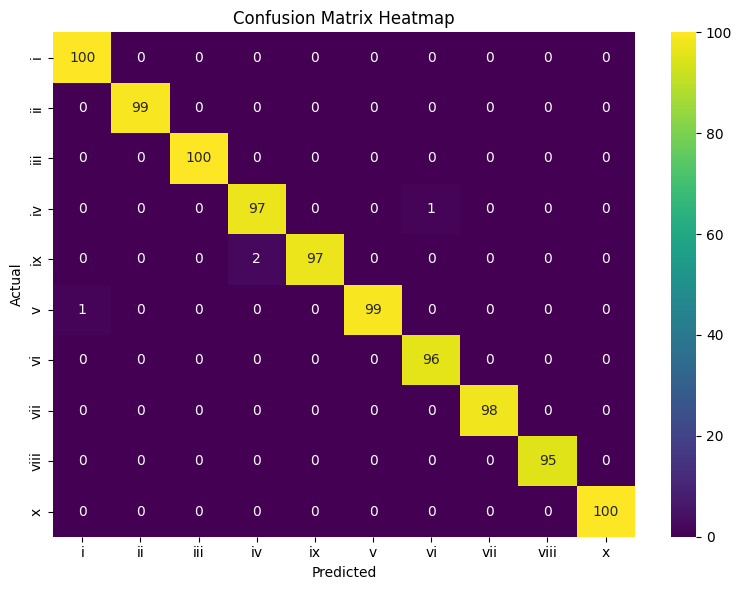

In [18]:
# Predict labels
y_true = test_gen.classes
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = list(test_gen.class_indices.keys())

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


2025-05-06 13:59:24.815331: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_83', 4 bytes spill stores, 4 bytes spill loads



30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step 


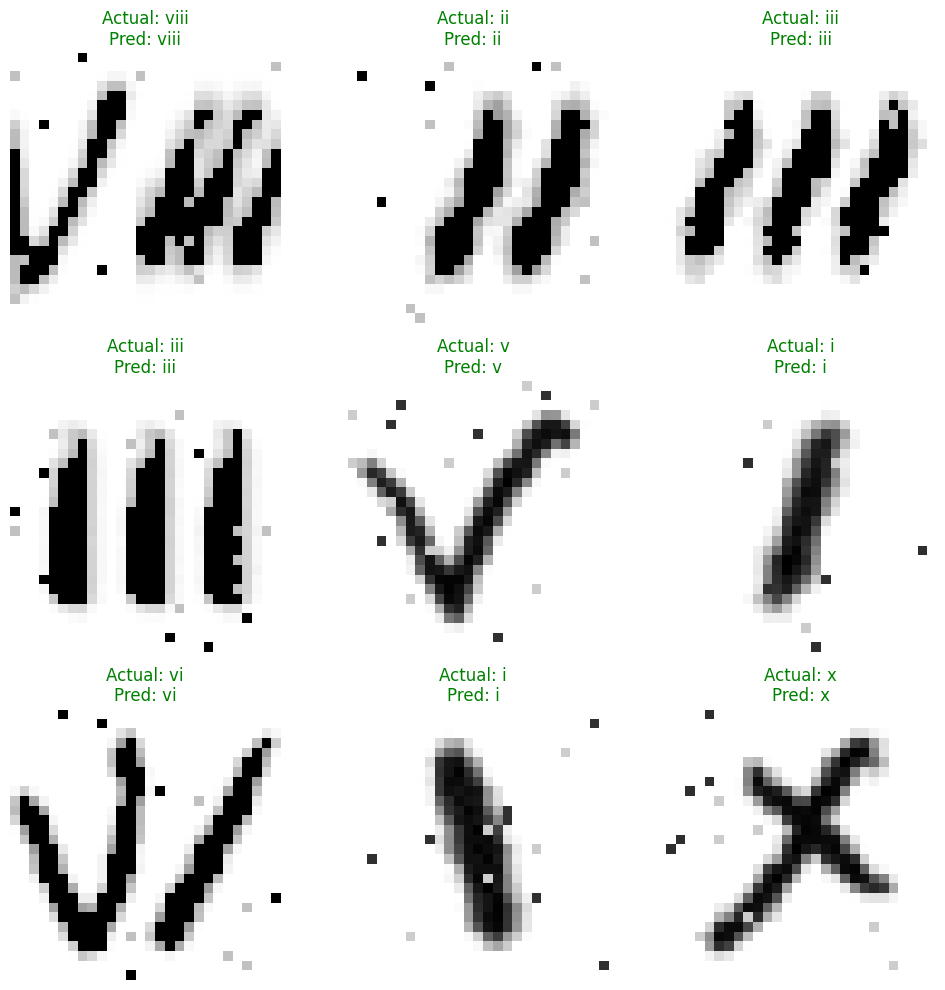

In [19]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Load all test images and labels
x_test, y_test = next(test_gen)
for _ in range((test_gen.samples // test_gen.batch_size) - 1):
    x_batch, y_batch = next(test_gen)
    x_test = np.concatenate((x_test, x_batch))
    y_test = np.concatenate((y_test, y_batch))

# Predict on all test images
preds = model.predict(x_test)
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(preds, axis=1)

# Map class indices to label names
idx_to_class = {v: k for k, v in test_gen.class_indices.items()}

# Pick 9 random indices
random_indices = random.sample(range(len(x_test)), 9)

# Plot
plt.figure(figsize=(10, 10))
for i, idx in enumerate(random_indices):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')
    actual = idx_to_class[y_true[idx]]
    predicted = idx_to_class[y_pred[idx]]
    color = 'green' if actual == predicted else 'red'
    plt.title(f"Actual: {actual}\nPred: {predicted}", color=color)
    plt.axis('off')
plt.tight_layout()
plt.show()


In [20]:
model.save('996.keras')